<p>CM1: We have implemented a fully connected DNN (best performing) to implement the classification problem. This part also contains an extra implementation of this problem using RNN to check out the number of cases of each class on a particular date. A forecast model has been created to visualize the cases for the future values.</p>

<p>CM2: All the necessary code blocks used to attend the best resulting fully connected DNN for this classification problem.</p>

<p>CM3: A detalied comparision of run time performance of all the different architectures and hyperparameter tuned models.</p>

<h2><center>ASSIGNMENT 4</center></h2>
<h2><center>DEEP ASHISH JARIWALA, JAYDEEP SINGH</center></h2>
<h2><center>GROUP - 41</center></h2>
<h2><center>Q: CM1</center></h2>

### IMPORTING LIBRARIES

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import plot_confusion_matrix


from numpy.random import seed
seed(200)
tf.random.set_seed(135)

### IMPORTING DATASET

In [88]:
dataset = pd.read_csv("COVID_dataset_train.csv")
dataset

,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Reporting_PHU_City,Outbreak_Related,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Outcome1
0,2020-03-30,2020-03-31,2020-03-31,2020-03-30,70s,MALE,OB,Stratford,Yes,43.368662,-81.001913,Fatal
1,2021-01-22,2021-01-24,2021-01-24,2021-01-23,50s,FEMALE,NO KNOWN EPI LINK,Newmarket,NaN,44.048023,-79.480239,Not Resolved
2,2020-03-24,2020-04-14,2020-04-14,2020-04-13,70s,FEMALE,OB,Toronto,Yes,43.656591,-79.379358,Resolved
3,2021-01-18,2021-01-21,2021-01-21,2021-01-18,<20,MALE,CC,Mississauga,NaN,43.647471,-79.708893,Not Resolved
4,2020-12-26,2020-12-28,2020-12-28,2020-12-26,60s,MALE,OB,Windsor,Yes,42.308796,-83.033670,Resolved
...,...,...,...,...,...,...,...,...,...,...,...,...
14855,2020-04-02,2020-04-03,2020-04-04,2020-04-02,90s,FEMALE,NO KNOWN EPI LINK,Whitby,NaN,43.898605,-78.940341,Fatal
14856,2021-01-25,2021-01-26,2021-01-26,2021-01-25,<20,MALE,CC,Thorold,NaN,43.116537,-79.241220,Not Resolved
14857,2020-12-07,2020-12-08,2020-12-08,2020-12-07,40s,FEMALE,CC,Mississauga,NaN,43.647471,-79.708893,Resolved
14858,2020-11-22,2020-11-24,2020-11-24,2020-11-22,20s,UNSPECIFIED,CC,Newmarket,NaN,44.048023,-79.480239,Resolved


### EXPLORATORY DATA ANALYSIS

<AxesSubplot:title={'center':'Distribution of Case acquisition info'}, xlabel='Reporting_PHU_Latitude', ylabel='Reporting_PHU_Longitude'>

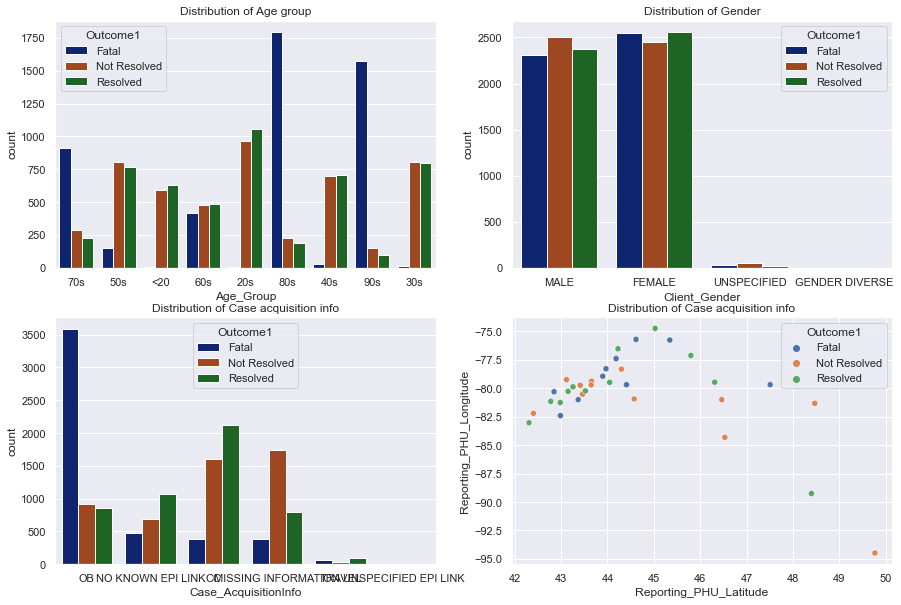

In [89]:
fig = plt.figure(figsize=(15,10))

plt.subplot(221)
plt.title("Distribution of Age group")
sns.countplot(x='Age_Group', hue='Outcome1', data = dataset, palette = 'dark')

plt.subplot(222)
plt.title("Distribution of Gender")
sns.countplot(x='Client_Gender', hue='Outcome1', data = dataset, palette = 'dark')

plt.subplot(223)
plt.title("Distribution of Case acquisition info")
sns.countplot(x='Case_AcquisitionInfo', hue='Outcome1', data = dataset, palette = 'dark')

plt.subplot(224)
plt.title("Distribution of Case acquisition info")
sns.scatterplot(x = 'Reporting_PHU_Latitude', y = 'Reporting_PHU_Longitude', hue = 'Outcome1', data = dataset)

<p><b>Important features observed from the plots:</b></p>
<ul>
            <li>The age group of 70s, 80s and 90s has observed the highest fatal outcomes compared to other classes.</li>
            <li>There is particular pattern observed in the gender histogram plot. All the classes of outcomes are equally divided among males and females. The unspecified also has an almost equal distribution of target.</li>
            <li>The case aquisition info provides one interesting pattern, The Outbreak(OB) class in acquissition info has the highest fatal outcomes.</li>
            <li>An interesting pattern is observed in longitude v/s latitude plot, The box covered by latitude(43,44) and longitude(-77.5,-82.5) has the cases with most fatal outcomes. This region can be a red zone.</li>
</ul>

### DATA CLEANING AND PREPROCESSING

The following steps are performed as a part of data preprocessing:
<ul>
    <b>--->Handling Null Values:</b><br>
            <li>Imputation of NaN values in the Outbreak_related columns, all the NaNs are replaced with "No".</li>
            <li>All the remaining NaN values were observed in Age_Group, Test Reported Date and Specimen Date, these values have been dropped.</li>
    <b>--->Handling Date Features:</b><br>
        <li>The given features of dates(Test_Reported_Date, Accurate_Episode_Date, Case_Reported_Date, Specimen_Date) are given as string, we will convert it to epoch seconds to extract some meaningful information from them. </li>
    <li>We are not using all the date features to train our model, instead we are only using Accurate_Episode_Date and Case_Reported_Date and we are dropping the columns Test_Reported_Date and Specimen_Date. This is because these two columns have values very similar values to the features Case_Reported_Date and Accurate_Episode_Date and these they can be dropped as they have a very high correlation with the other two columns</li>
    <li>Note that they are various other ways to capture information from Date Columns, for example, we can seperate Date into Day, Month and Year and create seperate columns for each or we can also breakdown the feature and treat it as a categorical value, and then perform-hot encoding. But all these features result in the creation of too many feature columns for neural network. Thus we use conversion of date to epoch timestamp as it is essentially representing same information with lesser number of features.</li>
                    <b>--->Label and one-hot encoding of features:</b><br>
            <li>Label encoding of Age_Group data as it is ordinal type of dataset. Moreover, the age wise ranking is also preserved in case of label encoding.</li>
            <li>Other categorical features (Client_Gender, Case_AcquisitionInfo, Reporting_PHU_City, Outbreak_Related) were transformed using One-Hot Encoding for better results.</li>
           <b>--->One-hot encoding of target variable:</b><br>
            <li>We perform One-hot encoding of target variable, so that the multiclass classification data is processed properly by Tensorflow Library, as we are using Categorical cross entropy as loss function during training.</li>
    <b>--->Standard Scaling of the dataset:</b><br>
            <li>We perform standard scaling of the train and test set so that the numeric values are centered around zero.</li>
</ul>

#### DEALING WITH NAN AND MISSING VALUES

In [90]:
# Handling Null values

# replacing NaN in Outbreak_Related with NO 
dataset['Outbreak_Related'] = dataset['Outbreak_Related'].fillna("No") 

# Dropping NaN values in Age_Group, Test_reported_date and specimen_date
dataset = dataset.dropna()

#### CONVERTING DATE FEATURES TO TIME STAMP

In [91]:
# Handling Date Features
dataset.Accurate_Episode_Date = pd.to_datetime(dataset.Accurate_Episode_Date)
dataset.Case_Reported_Date = pd.to_datetime(dataset.Case_Reported_Date)
dataset.Test_Reported_Date = pd.to_datetime(dataset.Test_Reported_Date)
dataset.Specimen_Date = pd.to_datetime(dataset.Specimen_Date)

dataset = dataset.drop(['Test_Reported_Date', 'Specimen_Date'],axis=1)

dataset.Case_Reported_Date = list(map(lambda x: x.timestamp(),dataset.Case_Reported_Date))
dataset.Accurate_Episode_Date = list(map(lambda x: x.timestamp(),dataset.Accurate_Episode_Date))

C:\Users\DEEP\anaconda3\envs\tf_gpu\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


#### ENCODING THE VARIABLES AND OUTCOME

In [92]:
## encoding of features
dataset_features = dataset.drop(['Outcome1'], axis = 1)

dataset_features['Age_Group'] = dataset_features['Age_Group'].replace({'<20': 1, '20s': 2, '30s': 3 , '40s': 4, '50s': 5, '60s': 6, '70s': 7, '80s': 8, '90s': 9})

categorical_cols = ['Client_Gender','Case_AcquisitionInfo','Reporting_PHU_City','Outbreak_Related']

# Create the encoder.
encoder = OneHotEncoder(categories = "auto", handle_unknown="error", sparse = False)

# Fit and transform encoder to X
array_hot_encoded = encoder.fit_transform(dataset_features[categorical_cols])

# convert it to a Data Frame
data_hot_encoded = pd.DataFrame(array_hot_encoded, index=dataset.index)

# set column names of encoded dataframe
data_hot_encoded.columns = encoder.get_feature_names(categorical_cols)

# concatenate other columns with the encoded columns to get the final datset
data_other_cols = dataset_features.drop(columns=categorical_cols)
dataset_temp = pd.concat([data_hot_encoded, data_other_cols], axis=1)
dataset_features = dataset_temp

In [93]:
## encoding of target variable
dataset_target = dataset['Outcome1']
dataset_target = pd.DataFrame(dataset_target, columns = ['Outcome1'])

categorical_cols = ['Outcome1']

# Create the encoder.
encoder_1 = OneHotEncoder(categories = "auto", handle_unknown="error", sparse = False)

# Fit and transform encoder to X
array_hot_encoded_1 = encoder_1.fit_transform(dataset_target)

# convert it to a Data Frame
data_hot_encoded_1 = pd.DataFrame(array_hot_encoded_1, index=dataset_target.index)

# set column names of encoded dataframe
data_hot_encoded_1.columns = encoder_1.get_feature_names(categorical_cols)

dataset_target_1 = data_hot_encoded_1

#### SPLITTING THE DATA INTO TEST AND TRAIN

In [94]:
# train-test split of the data
X_train, X_test, y_train, y_test = train_test_split(dataset_features, dataset_target_1, test_size = 0.10, random_state = 245)

#### SCALING THE NUMERIC FEATURES

In [95]:
# Scaling of test and train sets
from sklearn.preprocessing import StandardScaler
numeric_columns = ['Reporting_PHU_Longitude', 'Reporting_PHU_Latitude','Case_Reported_Date', 'Accurate_Episode_Date']

sc = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_columns] = sc.fit_transform(X_train[numeric_columns])
X_test_scaled[numeric_columns] = sc.transform(X_test[numeric_columns])

<p>The data is split into train and test sets with training set comprising of 90% of the total values, and test set with 10% values. Standard scaler is used to scale the numeric features and prepare the final dataset used for training</p>

## NEURAL NETWORK DESIGN:

We tried various different architectures of Neural network for the covid dataset, the designs for all those have been discussed in CM2 and CM3. Among all those models, we selected the following model for our implementation:

In [96]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import tensorflow as tf

# INITIALING ANN
ann = tf.keras.models.Sequential()

# ADDING INPUT LAYER AND FIRST HIDDEN LAYER
ann.add(tf.keras.layers.Dense(units = 112, activation='relu'))
ann.add(Dropout(0.07))

# ADDING SECOND HIDDEN LAYER
ann.add(tf.keras.layers.Dense(units=448, activation='relu', kernel_regularizer=l2(0.001)))

# ADDING THIRD HIDDEN LAYER
ann.add(tf.keras.layers.Dense(units=56, activation='relu'))

# ADDING OUTPUT LAYER
ann.add(tf.keras.layers.Dense(units=3, activation='softmax'))

ann.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [97]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_loss', patience = 10)

fitted_model = ann.fit(X_train_scaled, y_train, validation_split = 0.15, callbacks = [callback], epochs= 400, verbose=1)

Epoch 1/400

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

351/351 [==============================] - 1s 2ms/step - loss: 0.5478 - accuracy: 0.8198 - val_loss: 0.4038 - val_accuracy: 0.8726
Epoch 2/400
351/351 [==============================] - 0s 1ms/step - loss: 0.3776 - accuracy: 0.8824 - val_loss: 0.3374 - val_accuracy: 0.8862
Epoch 3/400
351/351 [==============================] - 0s 1ms/step - loss: 0.3434 - accuracy: 0.8906 - val_loss: 0.3325 - val_accuracy: 0.8827
Epoch 4/400
351/351 [==============================] - 0s 1ms/step - loss: 0.32

In [98]:
ann.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 112)               5824      
_________________________________________________________________
dropout_4 (Dropout)          (None, 112)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 448)               50624     
_________________________________________________________________
dense_18 (Dense)             (None, 56)                25144     
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 171       
Total params: 81,763
Trainable params: 81,763
Non-trainable params: 0
_________________________________________________________________


The main components of our neural network are:   

#### 1. Layers
A neural network consists of 3 different types layers: Input Layer, Hidden Layer and Output Layer.
<li>Input layer recieves the  initial data for the neural network.</li>
<li>Hidden layers are the intermediate layers between input and output layer and place where all the computation is done.</li>
<li>Output layers produce the result for given inputs.</li>
<p>Our model is a Fully Connected Deep Neural Network, where each node in a layer is connected to all the nodes in the next layer.Our Neural network consists of the following layers:</p>
<li>input layer with 112 neurons</li>
<li>2 hidden layers with 112 and 448 neurons respectively</li> 
<li>output layer with 3 neurons</li>
The total number of parameters in the neural network are 81,763.

#### 2. Activation Functions
Activation functions help the neural networks to learn complex patterns in the data. It takes in the output signal from the previous cell and converts it into some form that can be taken as input to the next cell. The most important feature of activation function is that it adds non-linearity to the model.
<p>
<li>After trying out different Activation functions for our model (Hyperparameter tuning details in CM3), we select ReLU activation function for our input and hidden layers. Compared to other activation functions like the sigmoid and tanh, the ReLU function offers much better performance and generalization in deep learning. The function is a nearly linear function that retains the properties of linear models, which makes them easy to optimize with gradient-descent methods.</li>
<li>The output layer uses the softmax activation function which will return the confidence scores of each class. This activation function is useful for multi-class classification as the scores returned by Softmax arre essentially the probablities of different classes which add to 1.
</li>
</p>


#### 3. Regularization Techniques
<p>
As deep neural networks often tend to overfit the training data, adding regularization to the model will help in reducing the overfitting by the reduction of generalization error and thus increase the variance of the model. In our model, we are applying the following regularization techniques to avoid overfitting:
</p>
<p>
<b>--->Dropout:</b><br>
Dropout is a regularization technique which helps in reducing overfitting by randomly selected nodes are dropped-out/ignored during training.
Our model has a dropout layer between the input and the first hidden layer, and the dropout rate being used in 0.05. i.e, it will randomly set 5% of inputs to zero.
</p>
<p>
<b>--->L2 Regularization:</b><br>
Regularization prevents overfitting by penalizing the weight matrices of the nodes. L2 regularization penalizes the sum of the square of the weights. For both small weight values and relatively large ones, L2 regularization transforms the values to a number close to 0, but not quite 0.
Our model uses L2 regularization at the 2nd layer with value of lambda = 0.01.
</p>

#### 4. Optimizer
Optimizers are algorithms or methods used to change the attributes of your neural network such as weights and learning rate in order to reduce the losses. After trying out various optimizers during hyper-parameter tuning, we found that Adam optimer gives the best performance among the all.(Details in CM3).
<p> Adam optimizer works with the momentums of first and second order. The advantage of using Adam optimizer is that it is very fast and converges rapidly. It also rectifies the vanishing learning rate</p>


#### 5. Early-stopping
A major issue with neural networks is the the number of training epochs to be used while training the model.Too many epochs can lead to overfitting of the training dataset, whereas too few may result in an underfit model. Early stopping is a method that allows you to specify an arbitrary large number of training epochs and it continues to monitor the validation loss and automatically stops the training if there is no improvement in the model.
<p>Our model uses early stopping during the training phase and thus it stops training after 23 epochs. Here we are using patience as 10, i.e the model will stop when it sees no change in the the validation loss over 10 epochs.</p>

#### 6. Loss Function
As the problem statement is a multi-class classification, the loss function we are using is the categorical cross entropy. It expects one-hot encoded representation of the labels as input. In this loss function, each predicted class probability is compared to the actual class desired output 0 or 1 and a score/loss is calculated that penalizes the probability based on how far it is from the actual expected value.

# RESULTS

### ACCURACY VS EPOCH PLOT

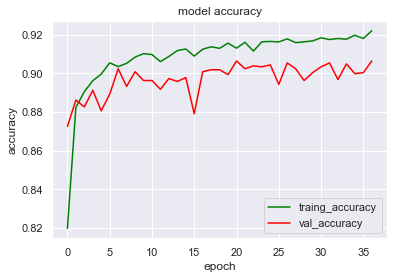

In [99]:
# summarize history for accuracy
plt.plot(fitted_model.history['accuracy'], c = 'green', label = 'traing_accuracy')
plt.plot(fitted_model.history['val_accuracy'], c = 'red', label = 'val_accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

It is observed that over the initial few epochs, the training set accuracy witness a very rapid increase, and after about 27 epochs, the model becomes stable and there very small difference between the validitation and the training accuracies.
During the training process, the maximum values of accuracies achieved on the training and the validation set are:

In [100]:
print("Mean validation accuracy:", np.mean(fitted_model.history['val_accuracy'])*100)
print("Mean training accuracy:", np.mean(fitted_model.history['accuracy'])*100)

Mean validation accuracy: 89.71797904452762
Mean training accuracy: 90.87539395770511


### LOSS V/S EPOCH PLOT

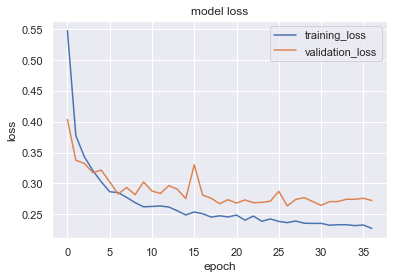

In [101]:
# summarize history for loss
plt.plot(fitted_model.history['loss'], label = "training_loss")
plt.plot(fitted_model.history['val_loss'], label = "validation_loss")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

It is observed that during the initial epochs, there is a huge gap between the training and validation loss. As the number of epochs increase, the difference between the training and validation losses keeps on decreasing. The minimum values of the these losses during the training phase are: 

In [102]:
print("Mean validation loss:", np.mean(fitted_model.history['val_loss'])*100)
print("Mean training loss:", np.mean(fitted_model.history['loss'])*100)

Mean validation loss: 28.81424451196516
Mean training loss: 26.572419058632207


### TEST SET ACCURACY

In [103]:
# FOR TESTING ON TRAINING SET
# check test set accuracy
results_train = ann.predict(X_test_scaled)

pred_values_train= []
for result in results_train:
    entry = [0,0,0]
    index = result.argmax()
    entry[index] = 1
    pred_values_train.append(entry)
    
from sklearn.metrics import confusion_matrix, accuracy_score
score = accuracy_score(y_test, pred_values_train)
print(f'The test set accuracy obtained: {score*100} %')

The test set accuracy obtained: 91.67235494880546 %


We observe that there our model gives an accuracy of 91.67% on the test set, which is very close to the accuracies obtained on the training and the validation sets.

### CONFUSION MATRIX ANALYSIS FOR OUR MODEL

In [104]:
result = []
for i in range(0, len(pred_values_train)):
    for j in range(3):
        if pred_values_train[i][j] == 1:
            if j == 0:
                result.append('Fatal')
            elif j == 1:
                result.append('Not Resolved')
            elif j == 2:
                result.append('Resolved')

In [105]:
y_test_arr = np.array(y_test)
result_original = []
for i in range(0, len(y_test_arr)):
    for j in range(3):
        if y_test_arr[i][j] == 1:
            if j == 0:
                result_original.append('Fatal')
            elif j == 1:
                result_original.append('Not Resolved')
            elif j == 2:
                result_original.append('Resolved')

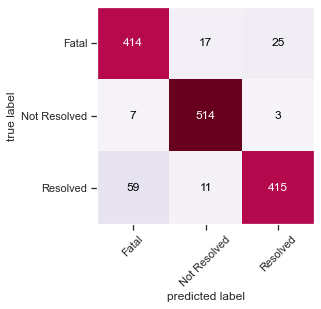

In [106]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

y_target = result_original
y_predicted = result

cm = confusion_matrix(y_target=y_target, y_predicted=y_predicted, binary=False)

fig, ax = plot_confusion_matrix(conf_mat=cm, cmap = 'PuRd' , class_names = ['Fatal','Not Resolved','Resolved'])
plt.show()

<p>The plot above shows the confusion matrix for the DNN based classification model. It can be seen that "Not Resolved" is classified at a better rate compared to other two classes. The highest error is observed in case of Resolved Cases which have been misclassified as fatal cases. However, the model provides a good accuracy in classifing the outcome for covid patient with majority of the data classified properly.</p>